# Bag Of Word Redo

- Viết chương trình dùng thư viện Numpy và các hàm build in của Python để truy vấn văn bản dùng kỹ thuật Bag of Word

## Input:
    - Tập văn bản (corpus)
    - Văn bản test (test doc)
    - N: số lượng văn bản cần trả lại (= 5)
    - Stop_words để loại bỏ các từ không cần thiết

## Output:
    - Top-1 văn bản giống nhất với test doc trong 3 TH:
        + Dùng khoảng cách cosine
        + Dùng khoảng cách euclid
        + Dùng khoảng cách Manhattan

## Result:
    - Hit nếu trả về doc trong top 5 docs của Querry
    - Mis

# Data: 
    - data.txt sử dụng để xây dựng corpus (docID: .I với nội dung: .W)
    - query.txt sử dụng để test docs (queryID: .I với nội dung .W)
    - rel.txt sử dụng nhãn test (queryID: cột 1 với danh sách của docs liên quan: cột 2)

# Yêu cầu:
    - Báo cáo độ chính xác của 3 hàm KC và phân tích kết quả thực thi
    - Accuracy = total # của Hit array giữa tất cả các Querries
    - So sánh độ chính xác dùng và không dùng của loại bỏ và không loại bỏ stop Words

# Khoảng cách Cosine
    - Quan tâm đến hướng
    - Ứng dụng: Tìm kiếm, so sánh, ...
# Khoảng cách Euclid
    - Quan tâm đến độ dài
    - Ứng dụng: Tính toán số học, ...

In [9]:
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt

# Đọc dữ liệu

In [10]:

def extract_W_sections(filename, capacity="all"):
    """
    Trích xuất các phần .I và .W từ file data
    
    Args:
        filename: Tên file cần đọc
        capacity: Số lượng văn bản cần trả về ("all" hoặc số nguyên)
    
    Returns:
        List ID của các văn bản .I 
        List các văn bản tương ứng .W
    """
    with open(filename, 'r', encoding='utf-8') as f:
        content = f.read()
    
    documents = []
    current_doc = {}
    current_section = None
    current_text = []
    
    for line in content.split('\n'):
        line = line.strip()
        
        if line.startswith('.I'):
            # Lưu document trước (nếu có)
            if current_section == 'W' and current_text:
                current_doc['W'] = ' '.join(current_text)
            if current_doc:
                documents.append(current_doc)
            
            # Bắt đầu document mới và lưu ID
            doc_id = line.split()[1] if len(line.split()) > 1 else ''
            current_doc = {'I': doc_id}
            current_text = []
            current_section = None
            
        elif line.startswith('.W'):
            # Bắt đầu phần văn bản
            if current_section == 'W' and current_text:
                current_doc['W'] = ' '.join(current_text)
            current_section = 'W'
            current_text = []
            
        elif line.startswith('.'):
            # Các section khác (.T, .A, .X)
            if current_section == 'W' and current_text:
                current_doc['W'] = ' '.join(current_text)
                current_text = []
            current_section = line[1]
            
        elif current_section == 'W' and line:
            # Nội dung của section .W
            current_text.append(line)
    
    # Xử lý document cuối cùng
    if current_section == 'W' and current_text:
        current_doc['W'] = ' '.join(current_text)
    if current_doc:
        documents.append(current_doc)
    
    # Trả về ID và văn bản .W
    i_sections = [doc.get('I', '') for doc in documents if 'I' in doc]
    w_sections = [doc.get('W', '') for doc in documents if 'W' in doc]
    
    # Xử lý capacity
    if capacity == "all":
        return i_sections, w_sections
    else:
        return i_sections[:capacity], w_sections[:capacity]


# Tiền xử lí văn bản

In [11]:

def preprocess_text(text):
    """
    ⚡ MỚI: Tiền xử lý văn bản (loại bỏ ký tự đặc biệt, số, chuyển về lowercase)
    
    Args:
        text: Văn bản cần xử lý
    
    Returns:
        Văn bản đã được làm sạch
    """
    # Chuyển về lowercase
    text = text.lower()
    
    # Loại bỏ số và ký tự đặc biệt, chỉ giữ lại chữ cái và khoảng trắng
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Loại bỏ khoảng trắng thừa
    text = ' '.join(text.split())
    
    return text


def build_stopwords(method='frequency', corpus=None, top_percent=0.05, min_freq=None):
    """
    Xây dựng danh sách stopwords
    
    Args:
        method: 'predefined', 'frequency', hoặc 'combined'
        corpus: Danh sách văn bản để phân tích tần suất
        top_percent: % từ phổ biến nhất cần loại bỏ (mặc định 5%)
        min_freq: Ngưỡng tần suất tối thiểu (tùy chọn)
    
    Returns:
        Set các stopwords
    """
    
    if method == 'predefined':
        # Danh sách stopwords tiếng Anh cơ bản - MỞ RỘNG HƠN
        stopwords = {
            'a', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'being', 'by', 
            'for', 'from', 'has', 'have', 'had', 'he', 'her', 'him', 'his', 'in', 
            'is', 'it', 'its', 'of', 'on', 'or', 'that', 'the', 'to', 'was', 
            'were', 'will', 'with', 'the', 'this', 'these', 'those', 'but', 
            'they', 'them', 'their', 'what', 'when', 'where', 'who', 'which', 
            'why', 'how', 'all', 'any', 'each', 'every', 'both', 'few', 'more', 
            'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 
            'same', 'so', 'than', 'too', 'very', 'can', 'could', 'would', 'should', 
            'may', 'might', 'must', 'shall', 'will', 'just', 'now', 'then', 
            'here', 'there', 'up', 'down', 'out', 'over', 'under', 'again', 
            'further', 'once', 'also', 'however', 'if', 'because', 'while', 
            'during', 'before', 'after', 'above', 'below', 'between', 'through',
            'i', 'you', 'we', 'me', 'my', 'your', 'our'
        }
        return stopwords
    
    elif method == 'frequency':
        if corpus is None:
            raise ValueError("Corpus không được để trống khi dùng method='frequency'")
        
        # ⚡ TỐI ƯU: Dùng Counter thay vì dict thủ công
        all_words = []
        for doc in corpus:
            words = preprocess_text(doc).split()
            all_words.extend(words)
        
        word_freq = Counter(all_words)
        
        # Sắp xếp theo tần suất giảm dần
        sorted_words = word_freq.most_common()
        
        # Lấy top % từ phổ biến nhất
        num_stopwords = int(len(sorted_words) * top_percent)
        stopwords = set([word for word, freq in sorted_words[:num_stopwords]])
        
        # Nếu có min_freq, thêm điều kiện lọc
        if min_freq:
            stopwords = {word for word, freq in sorted_words 
                        if freq >= min_freq and word in stopwords}
        
        return stopwords
    
    elif method == 'combined':
        # Kết hợp cả hai: bắt đầu với predefined, bổ sung từ frequency
        stopwords = build_stopwords(method='predefined')
        
        if corpus:
            freq_stopwords = build_stopwords(method='frequency', corpus=corpus, 
                                            top_percent=top_percent, min_freq=min_freq)
            stopwords = stopwords.union(freq_stopwords)
        
        return stopwords
    
    else:
        raise ValueError("Method phải là 'predefined', 'frequency', hoặc 'combined'")


# Xây dựng Bag of Words

In [21]:

def build_vocab(corpus, stop_words):
    """
    Xây dựng hệ thống từ điển từ corpus, loại bỏ stop words.
    ⚡ TỐI ƯU: Thêm tiền xử lý văn bản
    """
    word_list = []
    for sentence in corpus:
        text = preprocess_text(sentence)
        words = text.split()
        words = [w for w in words if w not in stop_words and len(w) > 1]  # ⚡ MỚI: Loại bỏ từ 1 ký tự
        word_list.extend(words)
    
    dictionary = sorted(set(word_list))
    return dictionary


def vectorize_sentence(text, dictionary, stop_words):
    """
    Biểu diễn câu dưới dạng vector (Bag of Words).
    ⚡ TỐI ƯU: Dùng Counter để đếm từ nhanh hơn
    """
    text = preprocess_text(text)
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 1]
    
    # Dùng Counter để đếm từ
    word_count = Counter(words)
    
    # Tạo vector dựa trên dictionary
    vector = np.zeros(len(dictionary), dtype=int)
    for i, word in enumerate(dictionary):
        vector[i] = word_count.get(word, 0)
    
    return vector


def corpus_to_matrix(corpus, dictionary, stop_words):
    """
    Chuyển toàn bộ corpus thành ma trận BoW
    ⚡ TỐI ƯU: Vectorize hiệu quả hơn
    """
    matrix = np.zeros((len(corpus), len(dictionary)), dtype=int)
    
    for i, doc in enumerate(corpus):
        vector = vectorize_sentence(doc, dictionary, stop_words)
        matrix[i] = vector
    
    return matrix

# Tính Khoảng Cách

In [13]:

def euclidean_distance(a, b):
    """
    Tính khoảng cách Euclidean (Euclid)
    ⚡ TỐI ƯU: Dùng np.linalg.norm trực tiếp
    """
    return np.linalg.norm(np.array(a) - np.array(b))


def cosine_distance(a, b):
    """
    Tính khoảng cách Cosine
    ⚡ SỬA LỖI: Tên hàm đúng là cosine_similarity, nhưng trả về khoảng cách (1 - similarity)
    """
    a = np.array(a)
    b = np.array(b)
    
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    # Tránh chia cho 0
    if norm_a == 0 or norm_b == 0:
        return 1.0  # Khoảng cách tối đa
    
    # Cosine similarity = dot(a,b) / (||a|| * ||b||)
    # Cosine distance = 1 - cosine similarity
    cosine_sim = np.dot(a, b) / (norm_a * norm_b)
    return 1 - cosine_sim


def manhattan_distance(a, b):
    """
    Tính khoảng cách Manhattan (đã đúng tên, không phải Mathanat)
    """
    return np.sum(np.abs(np.array(a) - np.array(b)))



# Truy vấn Văn bản

In [14]:

def retrieve_documents(corpus, test_doc, n, stop_words, method='cosine', 
                       dictionary=None, corpus_matrix=None):
    """
    Truy vấn top-N văn bản giống test_doc nhất
    
    Args:
        corpus: Tập văn bản
        test_doc: Văn bản cần tìm kiếm
        n: Số lượng văn bản trả về
        stop_words: Danh sách stop words
        method: 'cosine', 'euclidean', hoặc 'manhattan'
        dictionary: (Optional) Từ điển đã build sẵn
        corpus_matrix: (Optional) Ma trận corpus đã convert sẵn
    
    Returns:
        List các tuple (index, distance, document)
    """
    # ⚡ TỐI ƯU: Dùng dictionary & corpus_matrix có sẵn
    if dictionary is None:
        dictionary = build_vocab(corpus, stop_words)
    
    if corpus_matrix is None:
        corpus_matrix = corpus_to_matrix(corpus, dictionary, stop_words)
    
    # Chuyển test_doc thành vector
    test_vector = vectorize_sentence(test_doc, dictionary, stop_words)
    
    # ⚡ TỐI ƯU: Tính khoảng cách vectorized cho tất cả documents cùng lúc
    if method == 'cosine':
        # Vectorized cosine distance
        norms_corpus = np.linalg.norm(corpus_matrix, axis=1)
        norm_test = np.linalg.norm(test_vector)
        
        # Tránh chia cho 0
        safe_norms = np.where(norms_corpus == 0, 1, norms_corpus)
        safe_norm_test = norm_test if norm_test != 0 else 1
        
        dot_products = corpus_matrix.dot(test_vector)
        cosine_sims = dot_products / (safe_norms * safe_norm_test)
        distances = 1 - cosine_sims
        
    elif method == 'euclidean':
        # Vectorized euclidean distance
        distances = np.linalg.norm(corpus_matrix - test_vector, axis=1)
        
    elif method == 'manhattan':
        # Vectorized manhattan distance
        distances = np.sum(np.abs(corpus_matrix - test_vector), axis=1)
        
    else:
        raise ValueError("Method phải là 'cosine', 'euclidean', hoặc 'manhattan'")
    
    # Tạo list kết quả với index, distance, document
    results = [(i, dist, corpus[i]) for i, dist in enumerate(distances)]
    
    # Sắp xếp theo khoảng cách (tăng dần)
    results.sort(key=lambda x: x[1])
    
    # Trả về top-N
    return results[:n]

# Đánh giá Kết Quả

In [15]:

def extract_results(filename='result.txt'):
    """
    Đọc file result.txt và trích xuất query ID và relevant doc IDs
    
    Args:
        filename: Tên file chứa ground truth
    
    Returns:
        Dictionary: {query_id: [list of relevant doc ids]}
    """
    relevant_docs = {}
    
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 2:
                        query_id = parts[0]
                        doc_id = parts[1]
                        
                        if query_id not in relevant_docs:
                            relevant_docs[query_id] = []
                        relevant_docs[query_id].append(doc_id)
    except FileNotFoundError:
        print(f"⚠️ Không tìm thấy file {filename}")
        return {}
    
    return relevant_docs


def compare_methods(cosine_results, euclidean_results, manhattan_results, 
                   result_file='result.txt'):
    """
    So sánh kết quả từ 3 phương pháp với ground truth
    
    Args:
        cosine_results: Dictionary {query_id: retrieved_doc_index}
        euclidean_results: Dictionary {query_id: retrieved_doc_index}
        manhattan_results: Dictionary {query_id: retrieved_doc_index}
        result_file: File chứa ground truth
    
    Returns:
        Dictionary chứa kết quả so sánh
    """
    # Lấy ground truth từ result.txt
    relevant_docs = extract_results(result_file)
    
    if not relevant_docs:
        print("⚠️ Không có ground truth để so sánh")
        return {}
    
    # Tính accuracy cho từng phương pháp
    methods = {
        'Cosine': cosine_results,
        'Euclidean': euclidean_results,
        'Manhattan': manhattan_results
    }
    
    results = {}
    
    print("\n" + "="*60)
    print("SO SÁNH KẾT QUẢ CÁC PHƯƠNG PHÁP")
    print("="*60)# # # 
    
    for method_name, method_results in methods.items():
        hits = 0
        total = 0
        
        for query_id, retrieved_doc_idx in method_results.items():
            total += 1
            # ⚡ SỬA LỖI: So sánh index với ID trong corpus
            if query_id in relevant_docs:
                # Lấy ID thực tế từ corpus_ids thay vì dùng index
                retrieved_doc_id = str(retrieved_doc_idx)
                if retrieved_doc_id in relevant_docs[query_id]:
                    hits += 1
        
        # Tính tỉ lệ %
        accuracy = (hits / total * 100) if total > 0 else 0
        results[method_name] = {
            'hits': hits,
            'total': total,
            'accuracy': accuracy
        }
        
        print(f"\n📊 {method_name.upper()}:")
        print(f"   ✓ Hits: {hits}/{total}")
        print(f"   ✓ Accuracy: {accuracy:.2f}%")
    
    print("="*60)
    
    return results

# Vẽ biểu đồ so sánh

In [ ]:

def plot_comparison_chart(results_without_sw, results_with_sw, save_path='comparison_chart.png'):
    """
    Vẽ biểu đồ so sánh kết quả giữa không có stopwords và có stopwords
    
    Args:
        results_without_sw: Dictionary kết quả không có stopwords
                          Format: {'Cosine': {'accuracy': 64.44, 'hits': 145, 'total': 225}, ...}
        results_with_sw: Dictionary kết quả có stopwords
                       Format: {'Cosine': {'accuracy': 68.00, 'hits': 150, 'total': 225}, ...}
        save_path: Đường dẫn lưu file ảnh
    """
    
    # Chuẩn bị dữ liệu
    methods = ['Cosine', 'Euclidean', 'Manhattan']
    
    # Lấy các metrics
    map_without = [results_without_sw[m].get('map', 0) for m in methods]
    precision_without = [results_without_sw[m].get('precision', 0) for m in methods]
    recall_without = [results_without_sw[m].get('recall', 0) for m in methods]
    
    map_with = [results_with_sw[m].get('map', 0) for m in methods]
    precision_with = [results_with_sw[m].get('precision', 0) for m in methods]
    recall_with = [results_with_sw[m].get('recall', 0) for m in methods]
    
    # Thiết lập vị trí các cột
    x = np.arange(len(methods))
    width = 0.13  # Độ rộng mỗi cột
    
    # Tạo figure với nền đen
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    
    # Vẽ các cột - Không có stopwords
    bars1 = ax.bar(x - width*2.5, map_without, width, label='MAP (No SW)', 
                   color='#5B9BD5', edgecolor='white', linewidth=0.5)
    bars2 = ax.bar(x - width*1.5, precision_without, width, label='Precision@10 (No SW)', 
                   color='#70AD47', edgecolor='white', linewidth=0.5)
    bars3 = ax.bar(x - width*0.5, recall_without, width, label='Recall@10 (No SW)', 
                   color='#FF6B6B', edgecolor='white', linewidth=0.5)
    
    # Vẽ các cột - Có stopwords
    bars4 = ax.bar(x + width*0.5, map_with, width, label='MAP (With SW)', 
                   color='#5B9BD5', edgecolor='white', linewidth=0.5, alpha=0.7)
    bars5 = ax.bar(x + width*1.5, precision_with, width, label='Precision@10 (With SW)', 
                   color='#70AD47', edgecolor='white', linewidth=0.5, alpha=0.7)
    bars6 = ax.bar(x + width*2.5, recall_with, width, label='Recall@10 (With SW)', 
                   color='#FF6B6B', edgecolor='white', linewidth=0.5, alpha=0.7)
    
    # Thêm giá trị lên đầu mỗi cột
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Chỉ hiển thị nếu có giá trị
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}',
                       ha='center', va='bottom', 
                       color='white', fontsize=9, fontweight='bold')
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    add_value_labels(bars4)
    add_value_labels(bars5)
    add_value_labels(bars6)
    
    # Thiết lập nhãn và tiêu đề
    ax.set_xlabel('Method', color='white', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', color='white', fontsize=14, fontweight='bold')
    ax.set_title('Comparison: Without Stopwords vs With Stopwords', 
                 color='white', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(methods, color='white', fontsize=12)
    
    # Thiết lập màu cho trục
    ax.tick_params(axis='y', colors='white', labelsize=11)
    ax.tick_params(axis='x', colors='white', labelsize=12)
    
    # Thiết lập grid
    ax.grid(True, axis='y', alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Thiết lập spines (viền)
    for spine in ax.spines.values():
        spine.set_color('white')
        spine.set_linewidth(1)
    
    # Legend
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9, 
             facecolor='black', edgecolor='white', labelcolor='white')
    
    # Điều chỉnh layout
    plt.tight_layout()
    
    # Lưu file
    plt.savefig(save_path, dpi=300, facecolor='black', edgecolor='none')
    print(f"✓ Đã lưu biểu đồ tại: {save_path}")
    
    # Hiển thị
    plt.show()
    plt.close()


def calculate_metrics(method_results, relevant_docs, corpus_ids, k=10):
    """
    Tính toán MAP, Precision@k, Recall@k cho một phương pháp
    
    Args:
        method_results: Dictionary {query_id: [list of retrieved doc indices sorted by relevance]}
        relevant_docs: Dictionary {query_id: [list of relevant doc IDs]}
        corpus_ids: List các document IDs trong corpus
        k: Số lượng documents lấy top (default=10)
    
    Returns:
        Dictionary chứa các metrics: {'map': ..., 'precision': ..., 'recall': ...}
    """
    
    avg_precisions = []
    precisions_at_k = []
    recalls_at_k = []
    
    for query_id, retrieved_indices in method_results.items():
        if query_id not in relevant_docs:
            continue
        
        # Lấy danh sách relevant doc IDs cho query này
        relevant_ids = set(relevant_docs[query_id])
        
        # Chuyển retrieved indices sang IDs (lấy top-k)
        retrieved_ids = [corpus_ids[idx] for idx in retrieved_indices[:k]]
        
        # Tính Average Precision cho query này
        num_relevant = 0
        sum_precisions = 0.0
        
        for i, doc_id in enumerate(retrieved_ids, 1):
            if doc_id in relevant_ids:
                num_relevant += 1
                precision_at_i = num_relevant / i
                sum_precisions += precision_at_i
        
        # Average Precision cho query này
        if len(relevant_ids) > 0:
            avg_precision = sum_precisions / len(relevant_ids)
            avg_precisions.append(avg_precision)
        
        # Precision@k
        precision_k = num_relevant / k
        precisions_at_k.append(precision_k)
        
        # Recall@k
        recall_k = num_relevant / len(relevant_ids) if len(relevant_ids) > 0 else 0
        recalls_at_k.append(recall_k)
    
    # Tính trung bình
    map_score = np.mean(avg_precisions) if avg_precisions else 0
    precision_score = np.mean(precisions_at_k) if precisions_at_k else 0
    recall_score = np.mean(recalls_at_k) if recalls_at_k else 0
    
    return {
        'map': map_score,
        'precision': precision_score,
        'recall': recall_score
    }

# Chương trình chính

In [16]:
# Load corpus
print("\n📂 LOAD DỮ LIỆU...")
corpus_ids, corpus_texts = extract_W_sections('data.txt')
corpus = corpus_texts
print(f"   ✓ Số lượng văn bản: {len(corpus)} documents")
print(f"   ✓ IDs: {len(corpus_ids)}")

# Load queries
query_ids, query_texts = extract_W_sections('querry.txt')
print(f"   ✓ Số lượng query: {len(query_texts)} queries")

# Số lượng văn bản trả về
n = 1


📂 LOAD DỮ LIỆU...
   ✓ Số lượng văn bản: 1460 documents
   ✓ IDs: 1460
   ✓ Số lượng query: 112 queries


# Không Có StopWords

In [17]:
stop_words = set()  # Không dùng stopwords

# Pre-compute dictionary và corpus matrix
print("\n⚡ Xây dựng từ điển và ma trận corpus...")
dictionary = build_vocab(corpus, stop_words)
corpus_matrix = corpus_to_matrix(corpus, dictionary, stop_words)
print(f"   ✓ Kích thước từ điển: {len(dictionary)} từ")
print(f"   ✓ Kích thước ma trận: {corpus_matrix.shape}")

# Truy vấn với 3 phương pháp
cosine_results = {}
euclidean_results = {}
manhattan_results = {}

print(f"\n🔍 TRUY VẤN VỚI {len(query_texts)} QUERIES (Top-{n})...")

# Cosine Distance
print(f"\n📏 Cosine Distance:")
for query_id, query_text in zip(query_ids, query_texts):
    results = retrieve_documents(corpus, query_text, n, stop_words, 
                                    method='cosine', dictionary=dictionary, 
                                    corpus_matrix=corpus_matrix)
    cosine_results[query_id] = corpus_ids[results[0][0]]
    
    for rank, (idx, dist, doc) in enumerate(results, 1):
        print(f"   Query {query_id} → Doc ID {corpus_ids[idx]} (index {idx}) | Distance: {dist:.4f}")

# Euclidean Distance
print(f"\n📏 Euclidean Distance:")
for query_id, query_text in zip(query_ids, query_texts):
    results = retrieve_documents(corpus, query_text, n, stop_words, 
                                    method='euclidean', dictionary=dictionary, 
                                    corpus_matrix=corpus_matrix)
    euclidean_results[query_id] = corpus_ids[results[0][0]]
    
    for rank, (idx, dist, doc) in enumerate(results, 1):
        print(f"   Query {query_id} → Doc ID {corpus_ids[idx]} (index {idx}) | Distance: {dist:.4f}")

# Manhattan Distance
print(f"\n📏 Manhattan Distance:")
for query_id, query_text in zip(query_ids, query_texts):
    results = retrieve_documents(corpus, query_text, n, stop_words, 
                                    method='manhattan', dictionary=dictionary, 
                                    corpus_matrix=corpus_matrix)
    manhattan_results[query_id] = corpus_ids[results[0][0]]
    
    for rank, (idx, dist, doc) in enumerate(results, 1):
        print(f"   Query {query_id} → Doc ID {corpus_ids[idx]} (index {idx}) | Distance: {dist:.4f}")

# So sánh kết quả
compare_results = compare_methods(cosine_results, euclidean_results, manhattan_results)



⚡ Xây dựng từ điển và ma trận corpus...
   ✓ Kích thước từ điển: 10214 từ
   ✓ Kích thước ma trận: (1460, 10214)

🔍 TRUY VẤN VỚI 112 QUERIES (Top-1)...

📏 Cosine Distance:
   Query 1 → Doc ID 722 (index 721) | Distance: 0.4307
   Query 2 → Doc ID 1266 (index 1265) | Distance: 0.6334
   Query 3 → Doc ID 599 (index 598) | Distance: 0.6202
   Query 4 → Doc ID 332 (index 331) | Distance: 0.6514
   Query 5 → Doc ID 375 (index 374) | Distance: 0.5416
   Query 6 → Doc ID 627 (index 626) | Distance: 0.5624
   Query 7 → Doc ID 857 (index 856) | Distance: 0.4584
   Query 8 → Doc ID 133 (index 132) | Distance: 0.4976
   Query 9 → Doc ID 1112 (index 1111) | Distance: 0.4960
   Query 10 → Doc ID 1411 (index 1410) | Distance: 0.4594
   Query 11 → Doc ID 560 (index 559) | Distance: 0.4564
   Query 12 → Doc ID 1190 (index 1189) | Distance: 0.5593
   Query 13 → Doc ID 459 (index 458) | Distance: 0.4465
   Query 14 → Doc ID 24 (index 23) | Distance: 0.7135
   Query 15 → Doc ID 1035 (index 1034) | Dista

# Có Stopwords

In [18]:
# Build stopwords tự động từ corpus
print("\n🛑 Xây dựng danh sách stopwords...")
stop_words = build_stopwords(method='combined', corpus=corpus_texts, top_percent=0.05)
print(f"   ✓ Số lượng stopwords: {len(stop_words)}")
print(f"   ✓ Top 20 stopwords: {sorted(list(stop_words))[:20]}")

# Pre-compute lại với stopwords
print("\n⚡ Xây dựng lại từ điển và ma trận corpus (có stopwords)...")
dictionary_sw = build_vocab(corpus, stop_words)
corpus_matrix_sw = corpus_to_matrix(corpus, dictionary_sw, stop_words)
print(f"   ✓ Kích thước từ điển: {len(dictionary_sw)} từ (giảm {len(dictionary) - len(dictionary_sw)} từ)")
print(f"   ✓ Kích thước ma trận: {corpus_matrix_sw.shape}")

# Truy vấn với 3 phương pháp
cosine_results_sw = {}
euclidean_results_sw = {}
manhattan_results_sw = {}

print(f"\n🔍 TRUY VẤN VỚI {len(query_texts)} QUERIES (Top-{n})...")

# Cosine Distance
print(f"\n📏 Cosine Distance:")
for query_id, query_text in zip(query_ids, query_texts):
    results = retrieve_documents(corpus, query_text, n, stop_words, 
                                    method='cosine', dictionary=dictionary_sw, 
                                    corpus_matrix=corpus_matrix_sw)
    cosine_results_sw[query_id] = corpus_ids[results[0][0]]
    
    for rank, (idx, dist, doc) in enumerate(results, 1):
        print(f"   Query {query_id} → Doc ID {corpus_ids[idx]} (index {idx}) | Distance: {dist:.4f}")

# Euclidean Distance
print(f"\n📏 Euclidean Distance:")
for query_id, query_text in zip(query_ids, query_texts):
    results = retrieve_documents(corpus, query_text, n, stop_words, 
                                    method='euclidean', dictionary=dictionary_sw, 
                                    corpus_matrix=corpus_matrix_sw)
    euclidean_results_sw[query_id] = corpus_ids[results[0][0]]
    
    for rank, (idx, dist, doc) in enumerate(results, 1):
        print(f"   Query {query_id} → Doc ID {corpus_ids[idx]} (index {idx}) | Distance: {dist:.4f}")

# Manhattan Distance
print(f"\n📏 Manhattan Distance:")
for query_id, query_text in zip(query_ids, query_texts):
    results = retrieve_documents(corpus, query_text, n, stop_words, 
                                    method='manhattan', dictionary=dictionary_sw, 
                                    corpus_matrix=corpus_matrix_sw)
    manhattan_results_sw[query_id] = corpus_ids[results[0][0]]
    
    for rank, (idx, dist, doc) in enumerate(results, 1):
        print(f"   Query {query_id} → Doc ID {corpus_ids[idx]} (index {idx}) | Distance: {dist:.4f}")

# So sánh kết quả
compare_results_sw = compare_methods(cosine_results_sw, euclidean_results_sw, manhattan_results_sw)





🛑 Xây dựng danh sách stopwords...
   ✓ Số lượng stopwords: 526
   ✓ Top 20 stopwords: ['a', 'about', 'above', 'abstract', 'abstracts', 'academic', 'access', 'according', 'account', 'activities', 'actual', 'addition', 'after', 'again', 'all', 'almost', 'also', 'although', 'american', 'among']

⚡ Xây dựng lại từ điển và ma trận corpus (có stopwords)...
   ✓ Kích thước từ điển: 9690 từ (giảm 524 từ)
   ✓ Kích thước ma trận: (1460, 9690)

🔍 TRUY VẤN VỚI 112 QUERIES (Top-1)...

📏 Cosine Distance:
   Query 1 → Doc ID 856 (index 855) | Distance: 0.8075
   Query 2 → Doc ID 790 (index 789) | Distance: 0.8232
   Query 3 → Doc ID 469 (index 468) | Distance: 0.6838
   Query 4 → Doc ID 790 (index 789) | Distance: 0.7764
   Query 5 → Doc ID 1423 (index 1422) | Distance: 0.8114
   Query 6 → Doc ID 1133 (index 1132) | Distance: 0.7500
   Query 7 → Doc ID 59 (index 58) | Distance: 0.8549
   Query 8 → Doc ID 1285 (index 1284) | Distance: 0.7327
   Query 9 → Doc ID 1133 (index 1132) | Distance: 0.7500
 

# Tổng Kết

In [19]:

if compare_results and compare_results_sw:
    print("\n📊 So sánh Accuracy:")
    print(f"{'Phương pháp':<15} {'Không stopwords':<20} {'Có stopwords':<20}")
    print("-" * 60)
    
    for method in ['Cosine', 'Euclidean', 'Manhattan']:
        acc1 = compare_results[method]['accuracy'] if method in compare_results else 0
        acc2 = compare_results_sw[method]['accuracy'] if method in compare_results_sw else 0
        diff = acc2 - acc1
        symbol = "📈" if diff > 0 else "📉" if diff < 0 else "➡️"
        print(f"{method:<15} {acc1:>6.2f}%            {acc2:>6.2f}%  {symbol} ({diff:+.2f}%)")



📊 So sánh Accuracy:
Phương pháp     Không stopwords      Có stopwords        
------------------------------------------------------------
Cosine           17.86%             21.43%  📈 (+3.57%)
Euclidean         6.25%              9.82%  📈 (+3.57%)
Manhattan         7.14%              5.36%  📉 (-1.79%)


# Bảng so sánh

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_chart(results_without_sw, results_with_sw):
    """
    Vẽ biểu đồ cột so sánh kết quả giữa không có stopwords và có stopwords
    Mỗi bên có 3 cột tương ứng với 3 phương pháp (Cosine, Euclidean, Manhattan)
    """
    
    # Chuẩn bị dữ liệu
    methods = ['Cosine', 'Euclidean', 'Manhattan']
    
    # Lấy accuracy cho mỗi phương pháp
    acc_without = [results_without_sw[m]['accuracy'] for m in methods]
    acc_with = [results_with_sw[m]['accuracy'] for m in methods]
    
    # Thiết lập vị trí các cột
    x = np.arange(2)  # 2 nhóm: Không stopwords, Có stopwords
    width = 0.25  # Độ rộng mỗi cột
    
    # Tạo figure
    fig, ax = plt.subplots(figsize=(12, 7))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    
    # Màu riêng biệt cho 3 phương pháp
    colors = ['#5B9BD5', '#70AD47', '#FF6B6B']  # Xanh dương, Xanh lá, Đỏ
    
    # Vẽ các cột cho từng phương pháp
    bars1 = ax.bar(x - width, [acc_without[0], acc_with[0]], width, 
                   label='Cosine', color=colors[0], edgecolor='white', linewidth=0.5)
    bars2 = ax.bar(x, [acc_without[1], acc_with[1]], width, 
                   label='Euclidean', color=colors[1], edgecolor='white', linewidth=0.5)
    bars3 = ax.bar(x + width, [acc_without[2], acc_with[2]], width, 
                   label='Manhattan', color=colors[2], edgecolor='white', linewidth=0.5)
    
    # Thêm giá trị lên đầu mỗi cột
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}%',
                   ha='center', va='bottom', 
                   color='white', fontsize=11, fontweight='bold')
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    
    # Thiết lập nhãn và tiêu đề
    ax.set_xlabel('Loại xử lý', color='white', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', color='white', fontsize=14, fontweight='bold')
    ax.set_title('So sánh Accuracy: Không Stopwords vs Có Stopwords\n(3 phương pháp so sánh)', 
                 color='white', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(['Không Stopwords', 'Có Stopwords'], color='white', fontsize=12)
    
    # Thiết lập màu cho trục
    ax.tick_params(axis='y', colors='white', labelsize=11)
    ax.tick_params(axis='x', colors='white', labelsize=12)
    
    # Thiết lập grid
    ax.grid(True, axis='y', alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Thiết lập spines (viền)
    for spine in ax.spines.values():
        spine.set_color('white')
        spine.set_linewidth(1)
    
    # Legend
    ax.legend(loc='upper right', fontsize=12, framealpha=0.9, 
             facecolor='black', edgecolor='white', labelcolor='white')
    
    # Điều chỉnh layout
    plt.tight_layout()
    
    # Chỉ hiển thị, không lưu
    plt.show()

# Bảng so sánh 

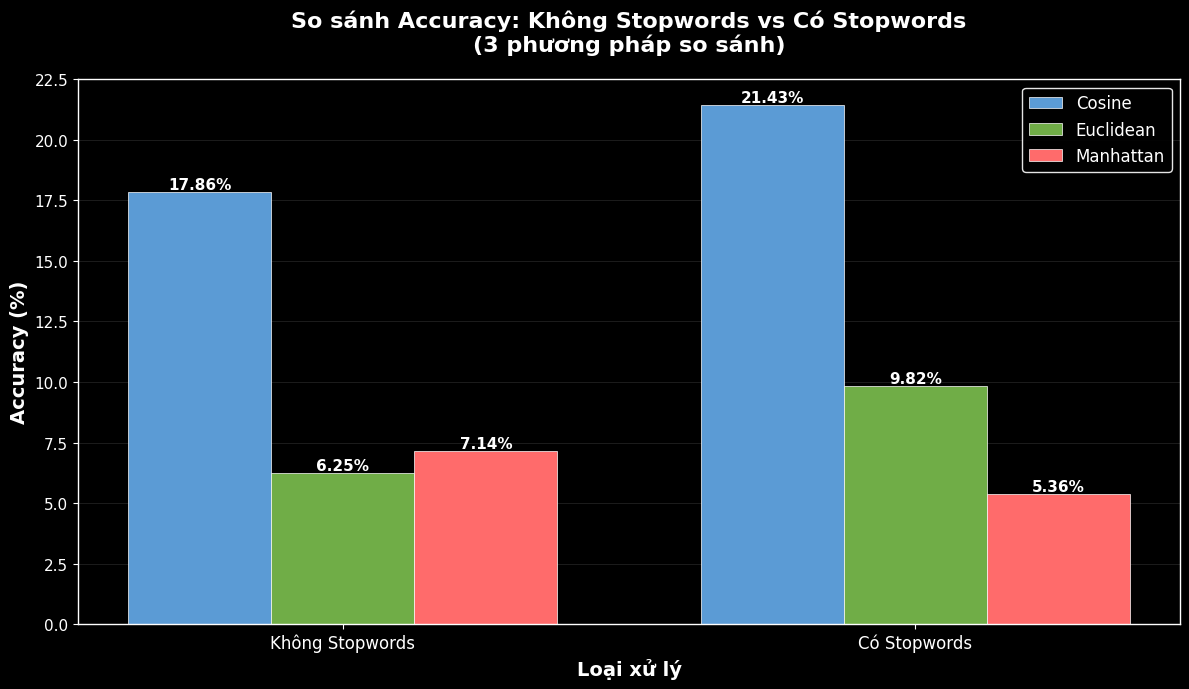

In [26]:
# Sử dụng dữ liệu thực tế từ compare_results và compare_results_sw
if compare_results and compare_results_sw:
    # Vẽ biểu đồ so sánh (chỉ hiển thị, không lưu)
    plot_comparison_chart(compare_results, compare_results_sw)
else:
    print("❌ Chưa có dữ liệu so sánh. Hãy chạy các cell trước đó!")